In [ ]:
using CSV, DataFrames, Dates
using PyCall
using DelimitedFiles

include("./src/cubes.jl")
include("./src/network.jl")
include("./src/motifs_discovery.jl")
include("./src/motifs_analysis.jl")

volume_tetrahedrons (generic function with 1 method)

In [ ]:
# Read data
path = "./data/"
region = "california"
filepath = path * region * ".csv"

df_full = CSV.read(filepath, DataFrame);

# Filters
if (region == "vrancea") || (region == "romania")
    df = df_full[df_full.Datetime .> DateTime(1976,1,1,0,0,0),:];

    df = df[(df.Latitude .>= 45.20) .& (df.Latitude .<= 46.0) .& 
            (df.Longitude .>= 26.0) .& (df.Longitude .<= 27.0) .&
            (df.Depth .>= 50.0) .& (df.Depth .<= 200.0), :];# .&
            # (df.Magnitude .> 1.0) .& (df.Magnitude .<= 4), :];

elseif region == "california"
    df = df_full[df_full.Datetime .> DateTime(1978,1,1,0,0,0),:];
    df[findall(df.Depth .< 0.001),:Depth] .= 0.0;
    println("california chosen; start year processed")
    
elseif region == "italy"
    # df = df_full[df_full.Datetime .> DateTime(1988,1,1,0,0,0),:];
    df = select(df_full, Not(:Event_Type))

elseif region == "japan"
    df = df_full[df_full.Datetime .> DateTime(1988,1,1,0,0,0),:];
end

"./data/california.csv"

In [ ]:
side = 5
minimum_magnitude = 2

df_filtered = df[df.Magnitude .> minimum_magnitude,:] 

# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,side=side,energyRelease=true);

# Create network
MG = create_network(df_filtered, df_filtered_cubes; edgeWeight=false)
connectivity = degree(MG);

2

## Method 1: Simple CurveFit using Least Squares

In [ ]:
using CurveFit
using Plots; gr()

include("./src/histogram_fit.jl")

power_law (generic function with 1 method)

In [ ]:
h, x,y = histogram_fit(connectivity)

(Histogram{Float64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  1.0:0.7840937252014543:712.9571024829205
weights: [180.0, 4822.0, 218.0, 1675.0, 0.0, 208.0, 815.0, 180.0, 488.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: false, Any[1.3920468626007272, 2.1761405878021813, 2.9602343130036357, 3.74432803820509], [0.03520810902646393, 0.9431861206978281, 0.04264093204316187, 0.3276310145518171])

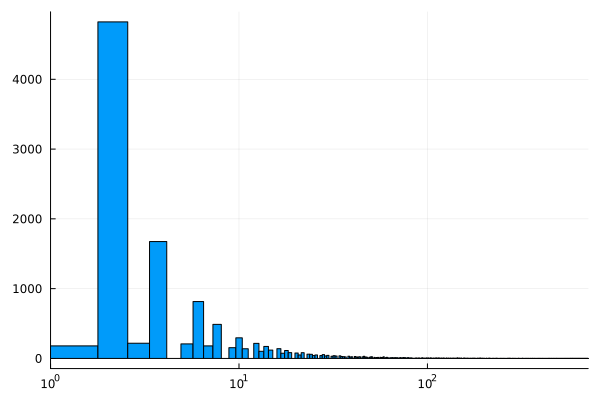

In [ ]:
plot(h ; label="",xscale=:log10, xlim=extrema(connectivity))

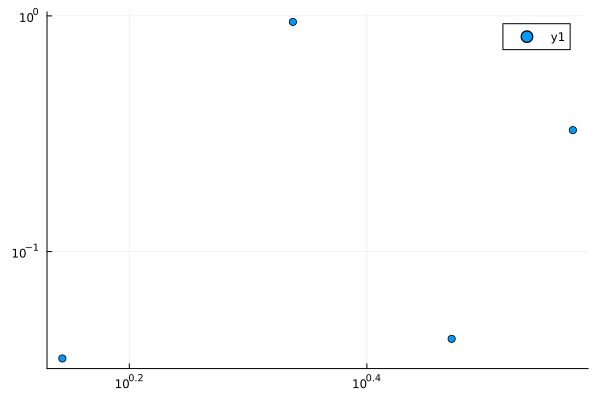

In [ ]:
scatter(x,y,xscale=:log10,yscale=:log10)

### Method 2 : MLE using python powerlaw package

In [ ]:
powerlaw = pyimport("powerlaw")

PyObject <module 'powerlaw' from '/home/gabipana/.local/lib/python3.8/site-packages/powerlaw.py'>

In [ ]:
py"""
import powerlaw as powerlaw
def fit_data_powerlaw(data):
    results = powerlaw.Fit(data, discrete=True)
    print(results.power_law.alpha)
    print(results.power_law.xmin)
    # R, p = results.distribution_compare('power_law', 'lognormal')
    return results.power_law.alpha, results.power_law.xmin

def plot_pdf(fit_data):
    pdf = powerlaw.pdf(fit_data)
    return pdf
"""

In [ ]:
a,xmin = py"fit_data_powerlaw"(connectivity)

(1.855919197686796, 6.0)

In [ ]:
pdf = py"plot_pdf"(connectivity)

([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 13.0, 16.0  …  86.0, 109.0, 137.0, 174.0, 220.0, 278.0, 352.0, 445.0, 563.0, 714.0], [0.014878492312778971, 0.39857827740122337, 0.018019507356587867, 0.13845263679947098, 0.017192924450322368, 0.04112249958670855, 0.026533311291122498, 0.017909296302419133, 0.010855788835620214, 0.008100512481401884  …  0.0006704505795264598, 0.00038094690462670797, 0.00028044777176865123, 0.0001943586833651307, 0.00011140900040969762, 4.560457413878612e-5, 1.898906676555875e-5, 7.999189415472565e-6, 2.1014819650817758e-6, 1.6422176945672156e-6])

In [ ]:
function power_law(x,b,a)
    return b*x .^(-a)
end

power_law (generic function with 1 method)

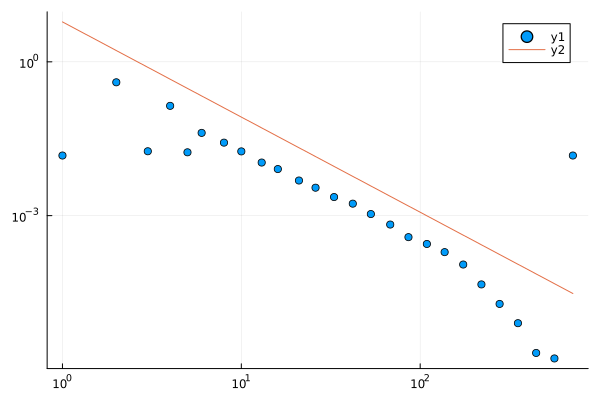

In [ ]:
scatter(pdf,xscale=:log10, yscale=:log10)
plot!(pdf[1],power_law(pdf[1],xmin,a))

In [ ]:
scatter(pdf,xscale=:log10, yscale=:log10)
plot!(pdf,power_law(pdf,xmin,a))

MethodError: MethodError: no method matching ^(::Vector{Float64}, ::Float64)
Closest candidates are:
  ^(!Matched::Symmetric{var"#s886", S} where {var"#s886"<:Real, S<:(AbstractMatrix{<:var"#s886"})}, ::Real) at /opt/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/symmetric.jl:683
  ^(!Matched::Symmetric{var"#s886", S} where {var"#s886"<:Complex, S<:(AbstractMatrix{<:var"#s886"})}, ::Real) at /opt/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/symmetric.jl:692
  ^(!Matched::UniformScaling, ::Number) at /opt/julia-1.8.5/share/julia/stdlib/v1.8/LinearAlgebra/src/uniformscaling.jl:317
  ...